# Training a VAE on MNIST
Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

    Navigate to Edit→Notebook Settings
    select GPU from the Hardware Accelerator drop-down
    
You can check if the GPU works with nvidia-smi.


## Data loading
Let's import some libraries and load the MNIST dataset.

In [2]:

# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import IPython.display
import numpy as np

bs = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)








Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Architecture specification

You can use the following encoder (don't forget that in a VAE the decoder has two heads, for the mean and the variance):
```
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
```
and this decoder:
```
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
```
Then, you need to complete the forward function. You can use Relu activations for every layers except for the heads that can reach negative values. Concerning the decoder head, you can use sigmoid to obtain values in [0,1].

Here we consider a latent space of dimension 2 but is could be any *zdim* dimension.

In [3]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(in_features=784, out_features=512, bias=True)
        self.fc2 = nn.Linear(in_features=512, out_features=256, bias=True)
        self.fc31 = nn.Linear(in_features=256, out_features=2, bias=True)
        self.fc32 = nn.Linear(in_features=256, out_features=2, bias=True)

        # decoder part
        self.fc4 = nn.Linear(in_features=2, out_features=256, bias=True)
        self.fc5 = nn.Linear(in_features=256, out_features=512, bias=True)
        self.fc6 = nn.Linear(in_features=512, out_features=784, bias=True)


    def encoder(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        mu = self.fc31(x)
        log_var = self.fc32(x)
        return  mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std) # std is used only for its dimensions
        z = mu + std * eps
        return z
        
    def decoder(self, z):
        z = self.fc4(z)
        z = F.relu(z)
        z = self.fc5(z)
        z = F.relu(z)
        z = self.fc6(z)
        z = F.sigmoid(z)
        return z


    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        image_rec = self.decoder(z)
        return image_rec, mu, log_var


## Loss function
The total loss of the VAE is composed of two terms: a reconstruction term and the KL divergence with the Prior. The KL divergence between two gaussians is given by:

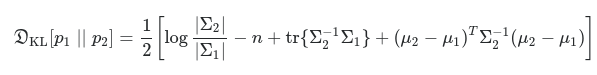

Assuming a unit gaussian as prior, we obtain a very simple equation that will help you to implement it in pytorch:

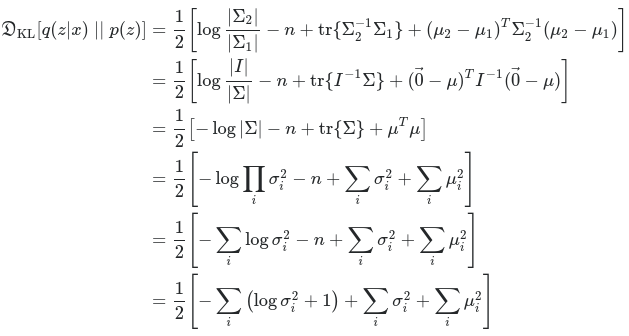

Note that, in these equations sigma denotes the standard deviation while the encoder network ouputs the log of the variance.  

In [4]:
# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
if torch.cuda.is_available():
    vae.cuda()
optimizer = optim.Adam(vae.parameters())

# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    RecLoss = F.mse_loss(recon_x, x.view(-1, 784), reduction='sum')
    KLDLoss = 0.5 * (-torch.sum(torch.add(log_var, 1)) + torch.sum(torch.exp(log_var)) + torch.sum(torch.square(mu)))
    return RecLoss + KLDLoss


## Training step
In this cell, we define the function that performs training on one epoch. We recommend to debug it using the "main loop" cell later in the page.

In [5]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae.forward(data)
        loss = loss_function(recon_batch, data.view(-1,784), mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

## Visualization:
We provide some visualization functions:

In [6]:

# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('gan_loss_epoch_%d.png' % epoch)

# Create a wall of generated MNIST images
def plotGeneratedImages(generatedImages,dim=(10, 10), figsize=(10, 10)):
    generatedImages=generatedImages.cpu().numpy()
    print(generatedImages.shape)
    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(np.squeeze(generatedImages[i]), interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)
    IPython.display.display(IPython.display.Image(data=('gan_generated_image_epoch_%d.png' % epoch)))


## Test
Complete the test function that generate new sample from latent space samples. 

In [7]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.cuda()
            recon, mu, log_var = vae.forward(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data.view(-1,784), mu, log_var)
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    with torch.no_grad():
      z = torch.randn(64, 2).cuda()
      generated = vae.decoder(z)
      plotGeneratedImages(generated.view(generated.size(0), 1, 28, 28))
      #save_image(sample.view(64, 1, 28, 28), '.sample_' + '.png')



## Main loop

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/60000 (0%)]	Loss: 182.365156
Train Epoch: 1 [10000/60000 (17%)]	Loss: 53.052061
Train Epoch: 1 [20000/60000 (33%)]	Loss: 44.084946
Train Epoch: 1 [30000/60000 (50%)]	Loss: 48.437480
Train Epoch: 1 [40000/60000 (67%)]	Loss: 42.312856
Train Epoch: 1 [50000/60000 (83%)]	Loss: 43.209438
====> Epoch: 1 Average loss: 47.2719
Train Epoch: 2 [0/60000 (0%)]	Loss: 41.085347
Train Epoch: 2 [10000/60000 (17%)]	Loss: 43.401655
Train Epoch: 2 [20000/60000 (33%)]	Loss: 41.038892
Train Epoch: 2 [30000/60000 (50%)]	Loss: 41.856592
Train Epoch: 2 [40000/60000 (67%)]	Loss: 39.461230
Train Epoch: 2 [50000/60000 (83%)]	Loss: 42.091885
====> Epoch: 2 Average loss: 40.1267
Train Epoch: 3 [0/60000 (0%)]	Loss: 38.583315
Train Epoch: 3 [10000/60000 (17%)]	Loss: 39.615234
Train Epoch: 3 [20000/60000 (33%)]	Loss: 39.967927
Train Epoch: 3 [30000/60000 (50%)]	Loss: 39.859238
Train Epoch: 3 [40000/60000 (67%)]	Loss: 38.155510
Train Epoch: 3 [50000/60000 (83%)]	Loss: 37.370215
====> Epoch: 3 Average

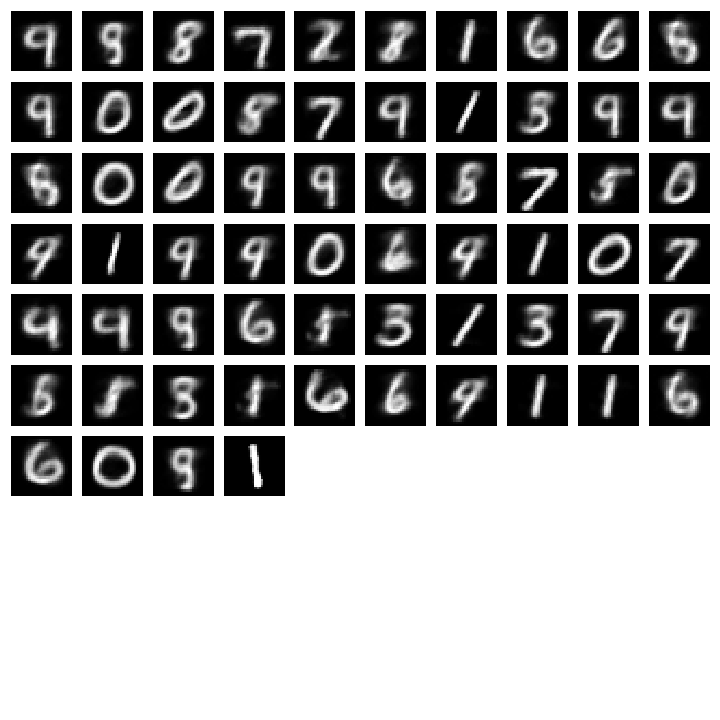

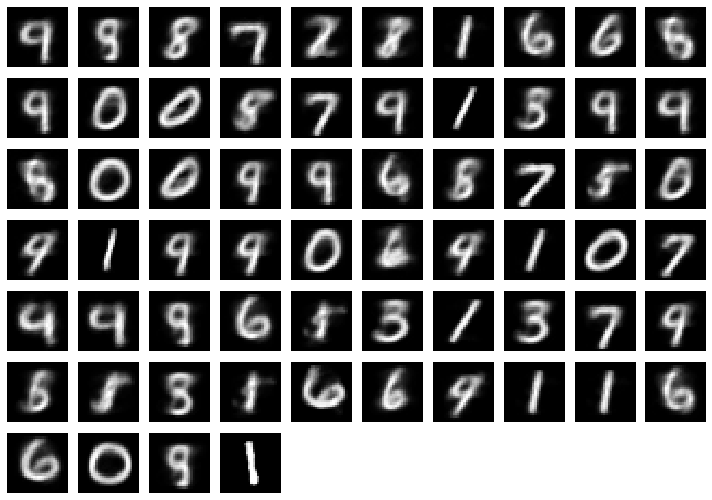

In [8]:

for epoch in range(1, 5):
    train(epoch)
test()
    

## Bonus 1: Interpolation
Sample two latent vectors z1 and z2 and generate the corresponding images. Then, generate 10 intermediate images by performing linear interpolation in the latent space between the z1 and z2.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


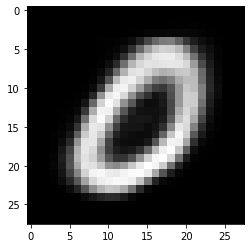

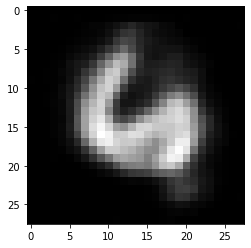

In [36]:
z1 = torch.tensor([torch.normal(torch.zeros(1), torch.ones(1)),torch.normal(torch.zeros(1), torch.ones(1))]).cuda()
z2 = torch.tensor([torch.normal(torch.zeros(1), torch.ones(1)),torch.normal(torch.zeros(1), torch.ones(1))]).cuda()

generated1 = vae.decoder(z1).cpu().detach()
generated2 = vae.decoder(z2).cpu().detach()

plt.imshow(np.squeeze(generated1).reshape(28,28), interpolation='nearest', cmap='gray')
plt.show()
plt.imshow(np.squeeze(generated2).reshape(28,28), interpolation='nearest', cmap='gray')
plt.show()

tensor([-1.1941, -1.2275], device='cuda:0')
tensor([-1.2310,  1.1897], device='cuda:0')
[-1.19405317 -1.22752929]


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


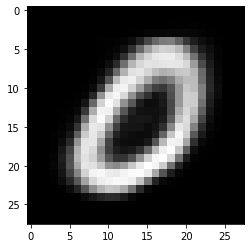

tensor([-1.1941, -1.2275], device='cuda:0')
tensor([-1.2310,  1.1897], device='cuda:0')
[-1.19774413 -0.98580873]


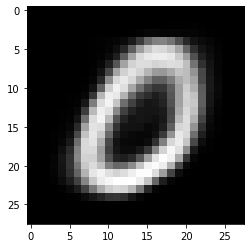

tensor([-1.1941, -1.2275], device='cuda:0')
tensor([-1.2310,  1.1897], device='cuda:0')
[-1.20143497 -0.74408817]


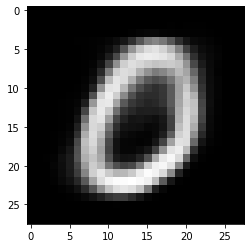

tensor([-1.1941, -1.2275], device='cuda:0')
tensor([-1.2310,  1.1897], device='cuda:0')
[-1.20512593 -0.50236768]


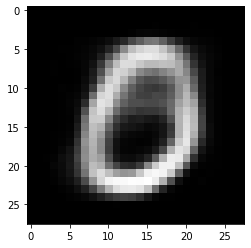

tensor([-1.1941, -1.2275], device='cuda:0')
tensor([-1.2310,  1.1897], device='cuda:0')
[-1.20881689 -0.26064712]


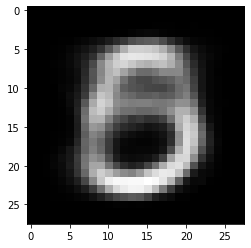

tensor([-1.1941, -1.2275], device='cuda:0')
tensor([-1.2310,  1.1897], device='cuda:0')
[-1.21250772 -0.0189265 ]


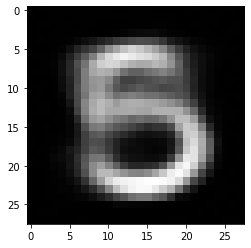

tensor([-1.1941, -1.2275], device='cuda:0')
tensor([-1.2310,  1.1897], device='cuda:0')
[-1.21619868  0.22279394]


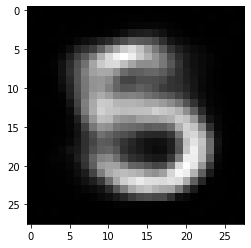

tensor([-1.1941, -1.2275], device='cuda:0')
tensor([-1.2310,  1.1897], device='cuda:0')
[-1.21988964  0.46451437]


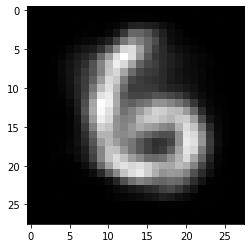

tensor([-1.1941, -1.2275], device='cuda:0')
tensor([-1.2310,  1.1897], device='cuda:0')
[-1.2235806   0.70623505]


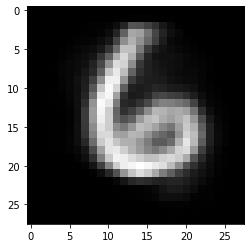

tensor([-1.1941, -1.2275], device='cuda:0')
tensor([-1.2310,  1.1897], device='cuda:0')
[-1.22727144  0.94795561]


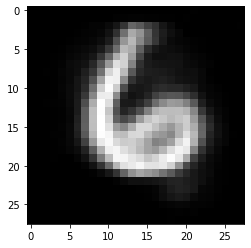

tensor([-1.1941, -1.2275], device='cuda:0')
tensor([-1.2310,  1.1897], device='cuda:0')
[-1.2309624   1.18967628]


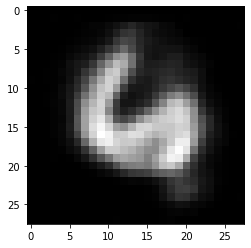

In [47]:
interp = np.zeros((11, 2))
for k in range(len(interp)):
    interp[k] = np.array([z1[0] + k * (z2[0] - z1[0]) / 10, z1[1] + k * (z2[1] - z1[1]) / 10])

for k in interp :
    print(z1)
    print(z2)
    print(k)
    generated = vae.decoder(torch.from_numpy(k).float().cuda()).cpu().detach()
    plt.imshow(np.squeeze(generated).reshape(28,28), interpolation='nearest', cmap='gray')
    plt.show()

## Bonus 2: Visualization
Generate a 10x10 mosaic by sampling *z* over a regulargrid in [-1,1]x[-1,1]. What do you observe? 


In [54]:
interp = np.zeros((11, 11, 2))
z1 = np.linspace(-1,1,11)
z2 = np.linspace(-1,1,11)

i = 0
for k in z1:
    h = 0
    for j in z2 :
        interp[i, h] = np.array([k, j])
        h += 1
    i += 1
print(interp[0])

[[-1.  -1. ]
 [-1.  -0.8]
 [-1.  -0.6]
 [-1.  -0.4]
 [-1.  -0.2]
 [-1.   0. ]
 [-1.   0.2]
 [-1.   0.4]
 [-1.   0.6]
 [-1.   0.8]
 [-1.   1. ]]


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


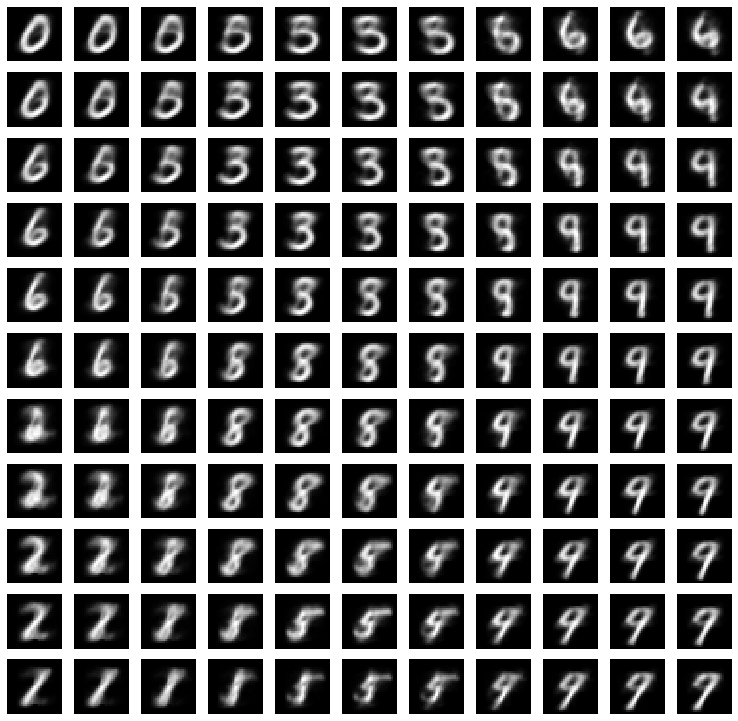

In [60]:
interp = np.zeros((11, 11, 2))
z1 = np.linspace(-1,1,11)
z2 = np.linspace(-1,1,11)

i = 0
for k in z1:
    h = 0
    for j in z2 :
        interp[i, h] = [k, j]
        h += 1
    i += 1

list_image = []
for k in interp :
    for j in k :
        generated = vae.decoder(torch.from_numpy(j).float().cuda()).cpu().detach()
        list_image.append(np.squeeze(generated).reshape(28,28))

k = 0 
plt.figure(figsize=(13,13))
for i in list_image :
    plt.subplot(11, 11, k+1)
    plt.imshow(i, interpolation='nearest', cmap='gray')
    plt.axis('off')
    k+=1

On peut voir que l'ensemble de la représentation graphique des nombres est contenu dans l'espace lattent de dimension deux.

Lorsqu'on se deplace dans cette espace, on fera apparaitre en décodant ce vecteur un "dégradé" des images des chiffres.